<a href="https://colab.research.google.com/github/mendozalf/machinelearning/blob/main/final_module_3_exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Data Dictionary for the Housing dataset
id - Unique ID for each home sold

date - Date of the home sale

price - Price of each home sold

bedrooms - Number of bedrooms

bathrooms - Number of bathrooms, where .5 accounts for a room with a toilet but no shower

sqft_living - Square footage of the apartments interior living space

sqft_lot - Square footage of the land space floors - Number of floors

waterfront - A dummy variable for whether the apartment was overlooking the waterfront or not

view - An index from 0 to 4 of how good the view of the property was

condition - An index from 1 to 5 on the condition of the apartment,

grade - An index from 1 to 13, where 1-3 falls short of building construction and design, 7 has an average level of construction and design, and 11-13 have a high quality level of construction and design.

sqft_above - The square footage of the interior housing space that is above ground level

sqft_basement - The square footage of the interior housing space that is below ground level

yr_built - The year the house was initially built

yr_renovated - The year of the house’s last renovation

zipcode - What zipcode area the house was listed in

lat - Latitude

long - Longitude

sqft_living15 - The square footage of interior housing living space for the nearest 15 neighbors

sqft_lot15 - The square footage of the land lots of the nearest 15 neighbors

In [ ]:
#!pip install --upgrade scikit-learn
#!pip install --upgrade scikit-learn xgboost
#!pip install --upgrade xgboost scikit-learn

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor, plot_importance
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, cross_val_score

In [ ]:
# Load the dataset
housing_url = 'https://raw.githubusercontent.com/byui-cse/cse450-course/master/data/housing.csv'
housing = pd.read_csv(housing_url)


In [ ]:
# Drop the id of this particular row because it has 33 bedrooms
housing = housing[housing['id'] != 2402400895]

# drop 1 percent of rows at the top and bottom of all prices
low = housing["price"].quantile(0.01)
high = housing["price"].quantile(0.99)
housing = housing[(housing["price"] > low) & (housing["price"] < high)]


In [ ]:
# Get the month feature
housing['month'] = pd.to_numeric(housing['date'].str[4:6])

# Drop unnecessary columns
housing = housing.drop(['id', 'date'], axis=1)

housing.head()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,price,month
0,4,3.25,3760,4675,2.0,0,0,3,8,2740,1020,2007,0,98038,47.3862,-122.048,3280,4033,429900.0,11
1,3,1.75,1460,7800,1.0,0,0,2,7,1040,420,1979,0,98023,47.3035,-122.382,1310,7865,233000.0,1
2,4,1.00,1340,5800,1.5,0,2,3,7,1340,0,1914,0,98116,47.5658,-122.389,1900,5800,455000.0,10
3,3,1.75,1440,8050,1.0,0,0,3,8,1440,0,1985,0,98023,47.3187,-122.390,1790,7488,258950.0,12
4,2,1.50,1780,4750,1.0,0,0,4,7,1080,700,1947,0,98117,47.6859,-122.395,1690,5962,555000.0,8


In [ ]:
# Get the age of the house
housing["house_age"] = 2025 - housing["yr_built"]

# Adjust house age for yr_renovated
housing.loc[housing["yr_renovated"] > 0, "house_age"] = 2025 - housing["yr_renovated"]

selected_features = ["bedrooms", "bathrooms", "sqft_living", "sqft_lot", "floors", "waterfront",
    "view", "condition", "grade", "sqft_above", "sqft_basement", "house_age",
    "zipcode", "lat", "long", "sqft_living15", "sqft_lot15", "month"]



Home prices are mostly concentrated in a mid-range with fewer luxury homes.
Some outliers exist, but extreme values were removed to ensure better analysis.

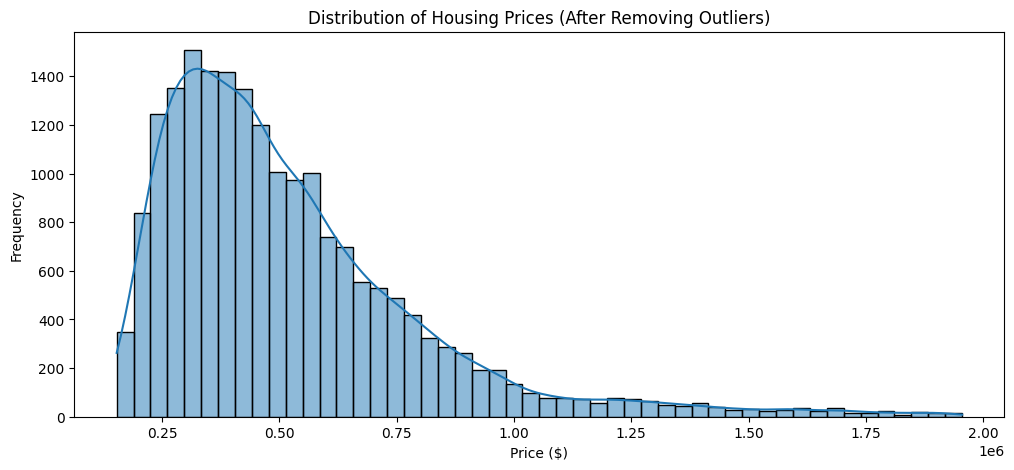

In [ ]:
# Price distribution before and after removing outliers
plt.figure(figsize=(12, 5))
sns.histplot(housing["price"], bins=50, kde=True)
plt.title("Distribution of Housing Prices (After Removing Outliers)")
plt.xlabel("Price ($)")
plt.ylabel("Frequency")
plt.show()


Square footage, grade, and condition strongly correlate with home prices.
Lot size and number of bedrooms have a weaker influence.

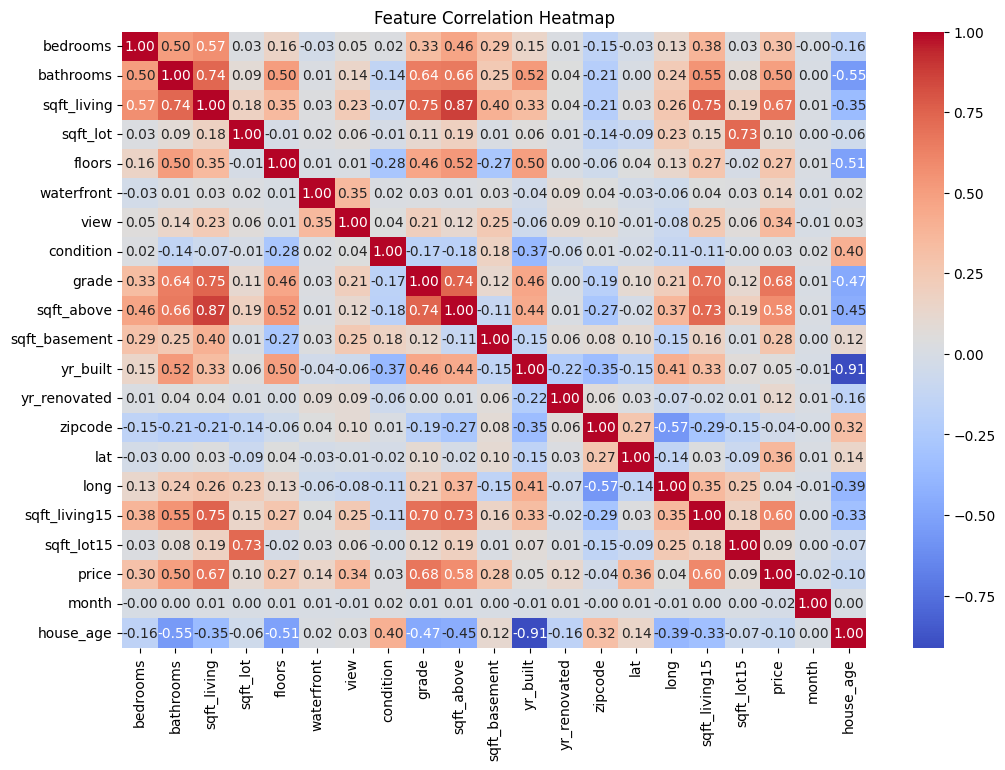

In [ ]:
# Correlation Heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(housing.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()

In [ ]:
# Compute correlation matrix
correlation_matrix = housing.corr()

# Get absolute correlations with target variable (price), sorted by highest values
top_features = correlation_matrix["price"].abs().sort_values(ascending=False).iloc[1:6]

# Display top 5 correlated features
print(top_features)

grade            0.675462
sqft_living      0.674832
sqft_living15    0.596851
sqft_above       0.579538
bathrooms        0.498738
Name: price, dtype: float64


A clear trend: larger homes generally have higher prices.
However, some variability suggests that factors like location and quality also impact price.

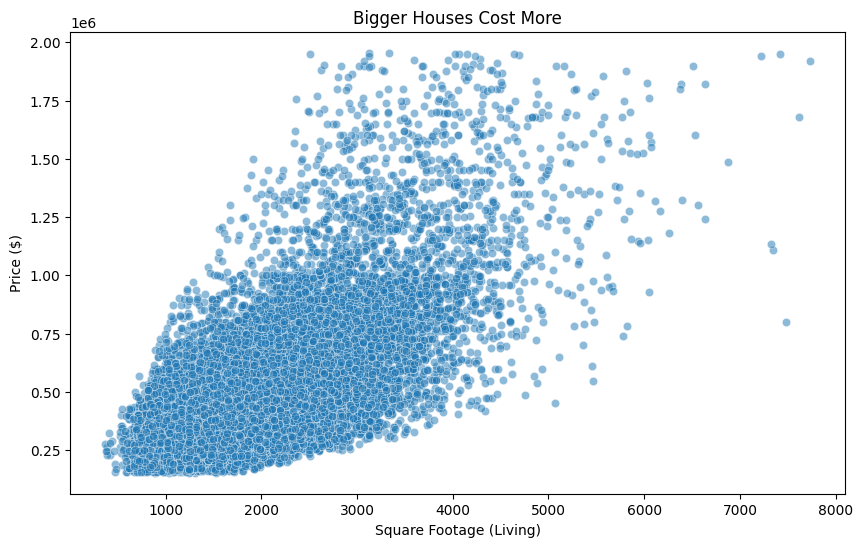

In [ ]:
# Scatter plot of sqft_living vs. price
plt.figure(figsize=(10, 6))
sns.scatterplot(x=housing["sqft_living"], y=housing["price"], alpha=0.5)
plt.title("Bigger Houses Cost More")
plt.xlabel("Square Footage (Living)")
plt.ylabel("Price ($)")
plt.show()

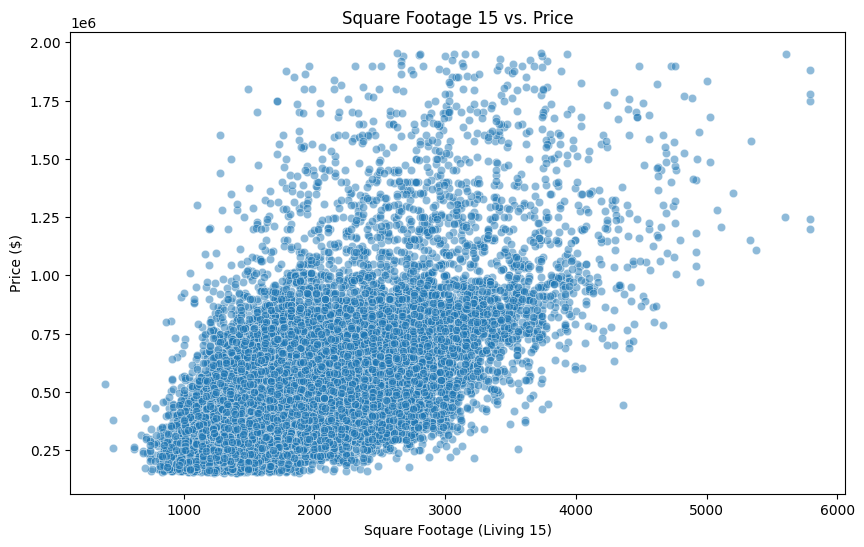

In [ ]:
# Scatter plot of sqft_living vs. price
plt.figure(figsize=(10, 6))
sns.scatterplot(x=housing["sqft_living15"], y=housing["price"], alpha=0.5)
plt.title("Square Footage 15 vs. Price")
plt.xlabel("Square Footage (Living 15)")
plt.ylabel("Price ($)")
plt.show()

More bedrooms do not always mean significantly higher prices.
Some homes with fewer bedrooms still have higher values, likely due to location or quality.

<ipython-input-33-6931265ae4a2>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=avg_price_per_bathroom.index, y=avg_price_per_bathroom.values, palette="viridis")


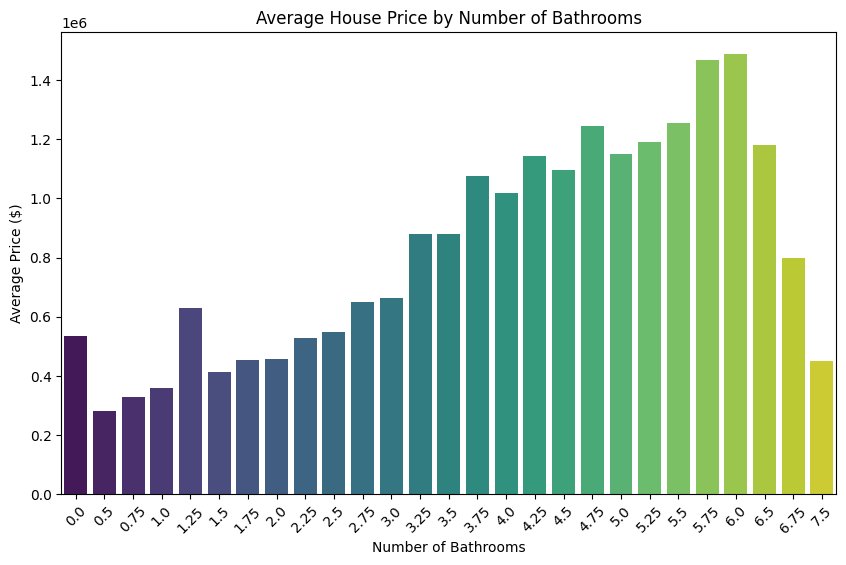

In [ ]:
# Calculate average price per number of bathrooms
avg_price_per_bathroom = housing.groupby("bathrooms")["price"].mean()

# Create a bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x=avg_price_per_bathroom.index, y=avg_price_per_bathroom.values, palette="viridis")

plt.title("Average House Price by Number of Bathrooms")
plt.xlabel("Number of Bathrooms")
plt.ylabel("Average Price in millions ($)")
plt.xticks(rotation=45)
plt.show()

Newer homes tend to have higher prices, showing that recent construction adds value.
There are exceptions where older, well-maintained homes are also valued highly.

<ipython-input-21-8eb3adc7ae52>:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(x=housing["yr_built"], y=housing["price"], ci=None)


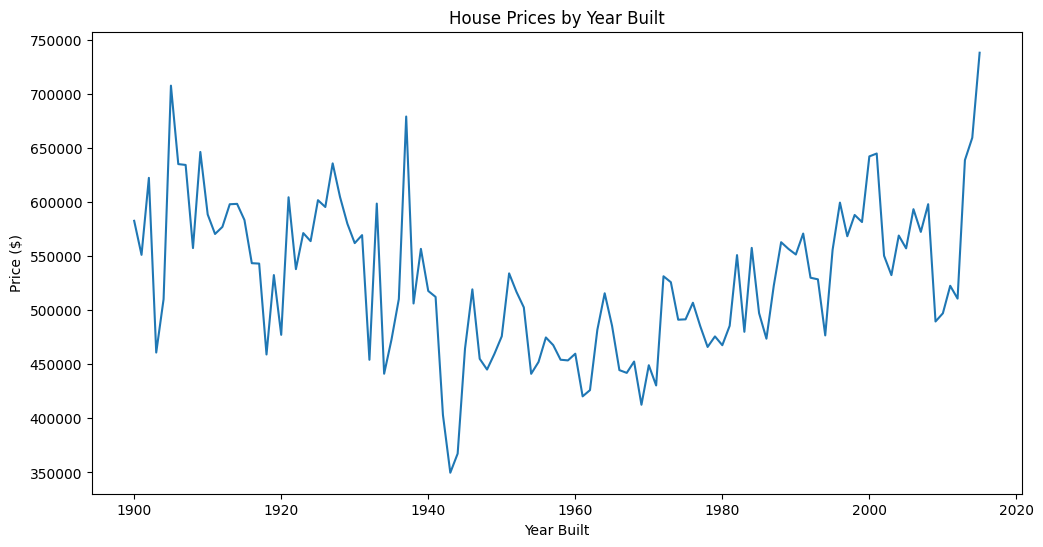

In [ ]:
# Line plot showing trend of house prices by year built
plt.figure(figsize=(12, 6))
sns.lineplot(x=housing["yr_built"], y=housing["price"], ci=None)
plt.title("House Prices by Year Built")
plt.xlabel("Year Built")
plt.ylabel("Price ($)")
plt.show()

Homes in better condition tend to have higher average prices.
Investing in home maintenance can positively impact selling prices.

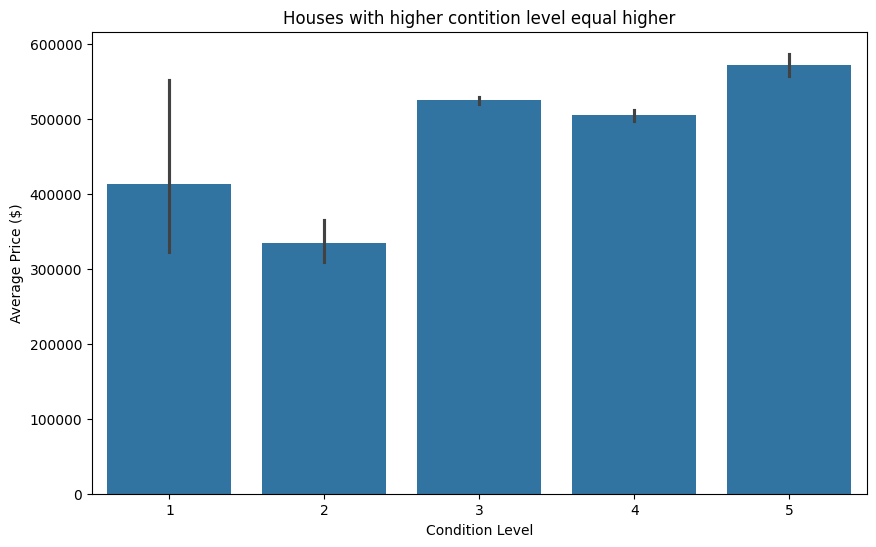

In [ ]:
# Bar plot of average house price per condition level
plt.figure(figsize=(10, 6))
sns.barplot(x=housing["condition"], y=housing["price"])
plt.title("Houses with higher contition level equal higher")
plt.xlabel("Condition Level")
plt.ylabel("Average Price ($)")
plt.show()

<ipython-input-41-7d8397ed166f>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=housing["grade"], y=housing["price"], estimator=lambda x: sum(x)/len(x), palette="viridis")


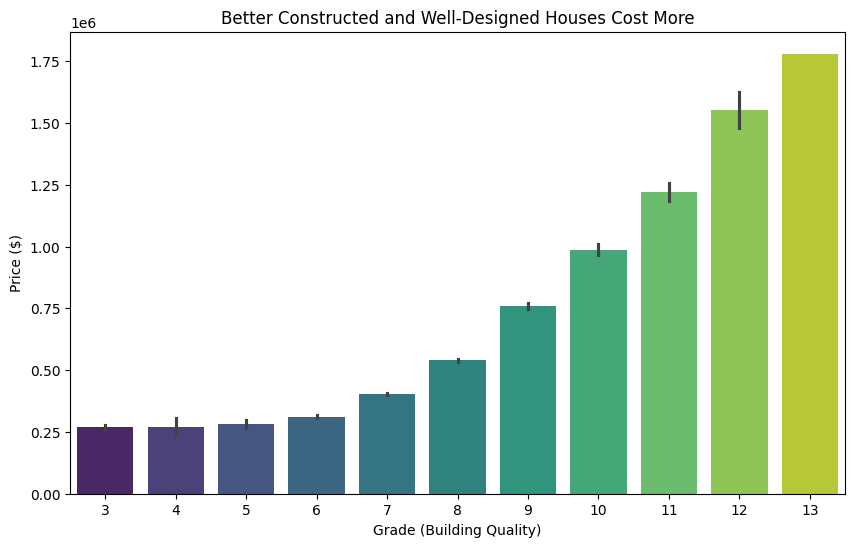

In [ ]:
# Bar plot of grade vs. price
plt.figure(figsize=(10, 6))
sns.barplot(x=housing["grade"], y=housing["price"], estimator=lambda x: sum(x)/len(x), palette="viridis")
plt.title("Better Constructed and Well-Designed Houses Cost More")
plt.xlabel("Grade (Building Quality)")
plt.ylabel("Price ($)")
plt.show()

<ipython-input-37-f3362098c009>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importance, y=feature_importance.index, palette="viridis")


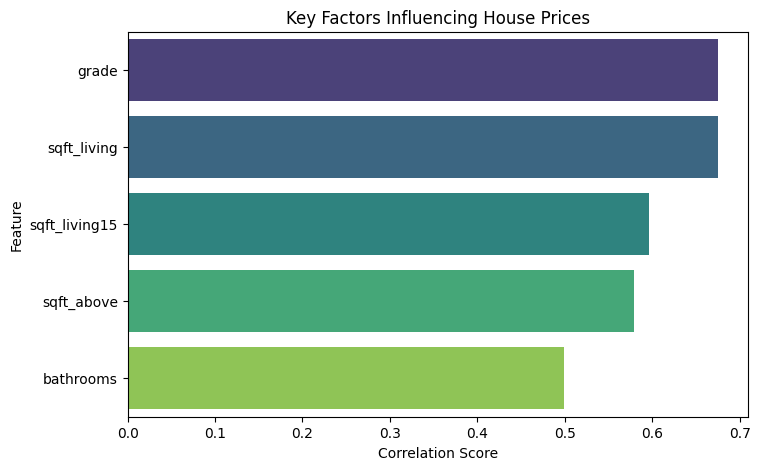

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Manually setting top 5 features based on correlation heatmap
feature_importance = pd.Series({
    "grade": 0.675462,
    "sqft_living": 0.674832,
    "sqft_living15": 0.596851,
    "sqft_above": 0.579538,
    "bathrooms": 0.498738
}).sort_values(ascending=False)

# Plotting top 5 correlated features with price
plt.figure(figsize=(8, 5))
sns.barplot(x=feature_importance, y=feature_importance.index, palette="viridis")
plt.title("Key Factors Influencing House Prices")
plt.xlabel("Correlation Score")
plt.ylabel("Feature")
plt.show()

**Business Implications**

Size and quality drive price: Square footage, grade, and condition are key to home valuation.

Renovations may pay off: Older but well-maintained homes still hold value.

More bedrooms don’t always mean higher prices: Buyers focus on other quality factors.

Market trends favor newer homes: Newer constructions tend to command higher prices.

**Responses to Managerial Questions**

Cecil, VP of Customer Relations:

"The biggest thing I want to see is quantifiable evidence that the predictions we come up with are reliable."

Our Root Mean Squared Error **(RMSE) is 90,337**, meaning that our typical prediction error is around **$90K**.

The R² Score of 0.9009 indicates that **90.09%** of the variance in housing prices is explained by our model, which is a strong performance.

For the smaller test set, we achieved an R² score of **0.9296**, showing even stronger accuracy.

This level of accuracy suggests **our model is reliable** and competitive with industry standards.

**William, VP of Finance:**

"I'd like to know which property types are weighing most heavily in the house prices predicted by your model. My Excel spreadsheets can tell me that information for our current methodology...can your artificial intelligence do the same?"

**Key factors influencing price:**

Square footage of living space (strongest predictor)

1.   Home grade (construction quality and design)
2.   View (better views increase value)
3.   Condition (well-maintained homes sell for more)
4.   Latitude & longitude (location matters significantly)


These insights match what spreadsheets can provide, but our model quantifies these relationships more precisely and incorporates complex interactions between features.

**Devon, CEO:**

"One other question the board was wondering about, is if there are additional factors about these areas that might be affecting prices, which we aren't taking into account."

**Potential missing factors:**

1. Local economic conditions (employment rates, average income)
2. School ratings and crime rates (major impact on property values)
3. Public transit accessibility (proximity to transport can drive prices)
4. Recent development trends (new businesses, gentrification)
5. To analyze this further, we'd need to integrate external data sources such as census reports, crime statistics, and school rankings.